In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import helpers.utils as utils
from helpers.constants import TREATMENT_LABEL, CONTROL_LABEL

In [ ]:
users_df, events_df, tasks_df, suggestions_df = utils.final_data_prep()
dfp = tasks_df.copy()
print(f"Number of participants: {len(users_df)}")

# To ensure that the order of countries is consistent across plots
countries = sorted(tasks_df['country'].unique())
groups = [CONTROL_LABEL, TREATMENT_LABEL]

### AI Reliance and Suggestion Acceptance Rate

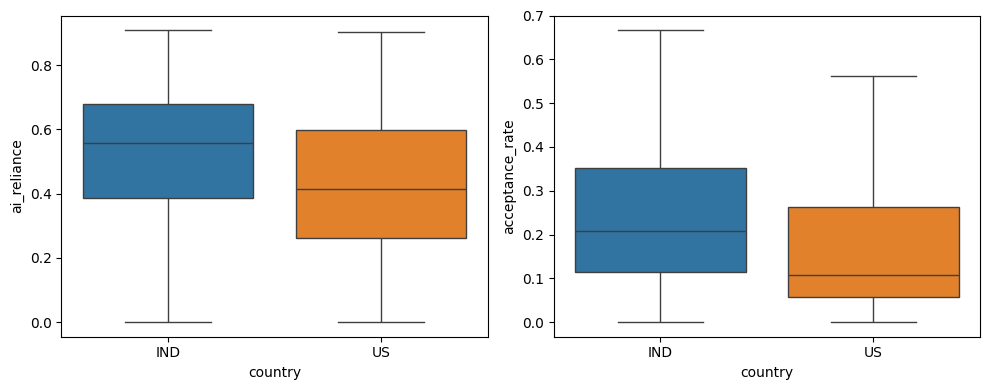

In [377]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.boxplot(x='country', y='ai_reliance', data=dfp, showfliers=False, order=countries, ax=axs[0], hue='country')
sns.boxplot(x='country', y='acceptance_rate', data=dfp, showfliers=False, order=countries, ax=axs[1], hue='country')
# sns.barplot(x='country', y='ai_reliance', data=dfp, order=countries, ax=axs[0], hue='country')
# sns.barplot(x='country', y='acceptance_rate', data=dfp, order=countries, ax=axs[1], hue='country')
plt.tight_layout()

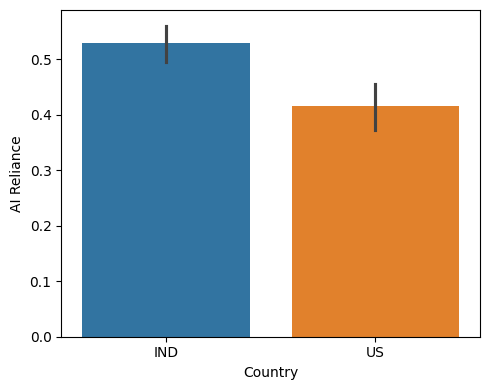

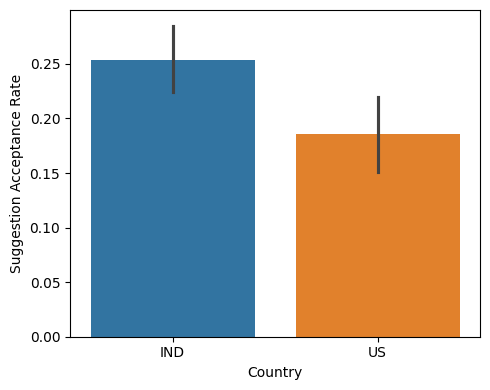

In [378]:
plt.figure(figsize=(5, 4))
# sns.boxplot(x='country', y='ai_reliance', data=dfp, showfliers=False, order=countries, hue='country')
sns.barplot(x='country', y='ai_reliance', data=dfp, order=countries, hue='country')
plt.xlabel('Country')
plt.ylabel('AI Reliance')
plt.tight_layout()
plt.savefig('plots/ai_reliance.png')

plt.figure(figsize=(5, 4))
# sns.boxplot(x='country', y='acceptance_rate', data=dfp, showfliers=False, order=countries, hue='country')
sns.barplot(x='country', y='acceptance_rate', data=dfp, order=countries, hue='country')
plt.xlabel('Country')
plt.ylabel('Suggestion Acceptance Rate')
plt.tight_layout()
plt.savefig('plots/acceptance_rate.png')

In [343]:
metric = 'ai_reliance' # acceptance_rate or ai_reliance
display(dfp[dfp['group'] == TREATMENT_LABEL].groupby('country')[metric].agg(['mean', 'std']))

ind = dfp[(dfp['group'] == TREATMENT_LABEL) & (dfp['country'] == 'IND')][metric]
us = dfp[(dfp['group'] == TREATMENT_LABEL) & (dfp['country'] == 'US')][metric]

print(stats.kstest(ind, 'norm'))
print(stats.kstest(us, 'norm'))

# Since not normally distributed, use Mann-Whitney U test
print(stats.mannwhitneyu(ind, us))

# Effect size
cliffs_d = (2*stats.mannwhitneyu(ind, us)[0] / (len(ind) * len(us))) - 1
print(cliffs_d)

,mean,std
country,,
IND,0.253694,0.190559
US,0.185507,0.1904


KstestResult(statistic=0.5008774519964297, pvalue=6.12125580242659e-34, statistic_location=0.0196078431372549, statistic_sign=-1)
KstestResult(statistic=0.5, pvalue=2.4272201332390136e-27, statistic_location=0.0, statistic_sign=-1)
MannwhitneyuResult(statistic=10748.0, pvalue=7.050321666754384e-05)
0.28687739463601525


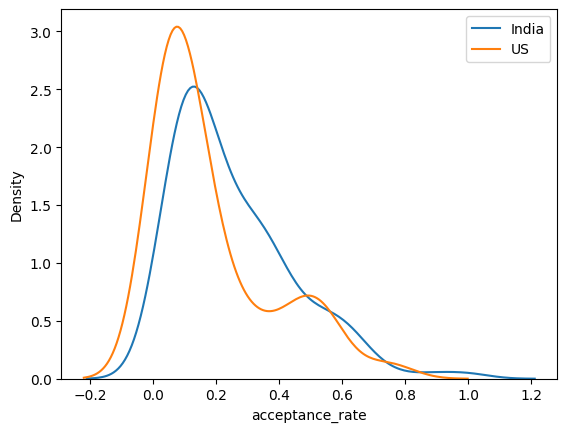

In [26]:
sns.kdeplot(ind, label='IND')
sns.kdeplot(us, label='US')
plt.legend()
plt.show()

In [341]:
# Perform statistical tests
dft = dfp[dfp.group == TREATMENT_LABEL]

df_normality = utils.perform_normality_test(dft, ['ai_reliance', 'acceptance_rate'], filter_col='country', filter_vals=countries)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['ai_reliance', 'acceptance_rate'], filter_col='country', filter_vals=countries, test_name='mannwhitney')
display(df_stats)

,col,shapiro_IND,shapiro_US,shapiro_IND_interpretation,shapiro_US_interpretation
0,ai_reliance,4.872988e-02,6.260764e-03,Not normal,Not normal
1,acceptance_rate,1.794137e-08,2.107842e-10,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,ai_reliance,10614.000000,0.000175,0.270833,True
1,acceptance_rate,10748.000000,0.000071,0.286877,True


### Suggestion editing metrics

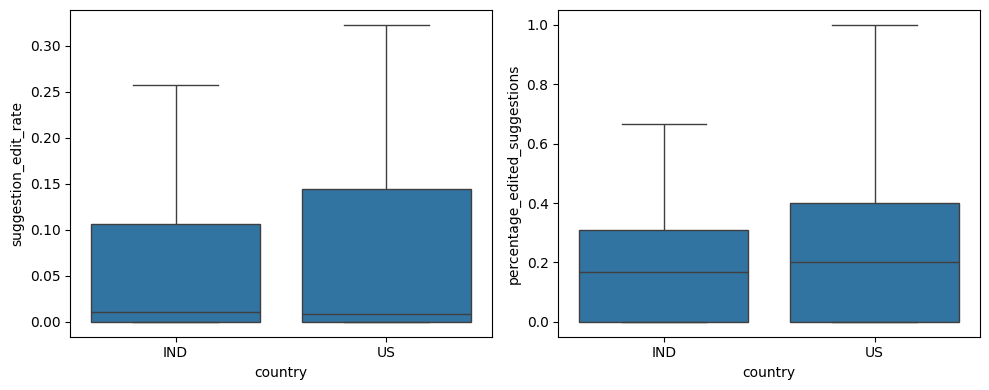

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.boxplot(x='country', y='suggestion_edit_rate', data=dfp, showfliers=False, order=countries, ax=axs[0])
sns.boxplot(x='country', y='percentage_edited_suggestions', data=dfp, showfliers=False, order=countries, ax=axs[1])
plt.tight_layout()

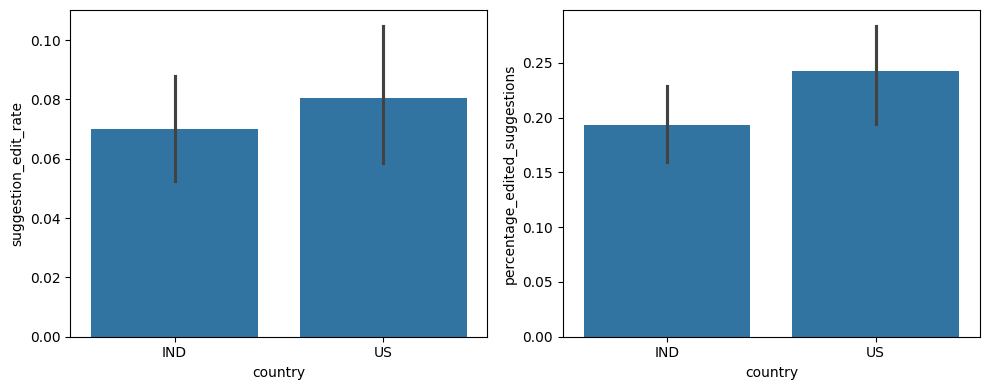

In [139]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.barplot(x='country', y='suggestion_edit_rate', data=dfp, order=countries, ax=axs[0])
sns.barplot(x='country', y='percentage_edited_suggestions', data=dfp, order=countries, ax=axs[1])
plt.tight_layout()

In [50]:
# Perform statistical tests
dft = dfp[(dfp.group == TREATMENT_LABEL) & (~dfp['suggestion_edit_rate'].isnull())]

df_normality = utils.perform_normality_test(dft, ['suggestion_edit_rate', 'percentage_edited_suggestions'], filter_col='country', filter_vals=countries)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['suggestion_edit_rate', 'percentage_edited_suggestions'], filter_col='country', filter_vals=countries, test_name='mannwhitney')
display(df_stats)

,col,shapiro_IND,shapiro_US,shapiro_IND_interpretation,shapiro_US_interpretation
0,suggestion_edit_rate,2.520859e-16,7.995629e-13,Not normal,Not normal
1,percentage_edited_suggestions,8.022794e-12,1.282860e-08,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,suggestion_edit_rate,7221.000000,0.600121,-0.038162,False
1,percentage_edited_suggestions,6699.500000,0.138452,-0.107626,False


In [4]:
# Set random state for pandas
np.random.seed(53423)

# Compute the percentage of tasks in India and US in which a suggestion was edited
# Bootstrap to get a distribution
perc_tasks_edited_ind = []
perc_tasks_edited_us = []
for _ in range(100):
    dft = dfp[dfp.group == TREATMENT_LABEL].sample(frac=0.8, replace=True)
    perc = (dft[dft.suggestion_edit_rate > 0].groupby(['country']).size() / dft.groupby(['country']).size()) * 100
    perc_tasks_edited_ind.append(perc['IND'])
    perc_tasks_edited_us.append(perc['US'])

print("Check normality")
print(stats.shapiro(perc_tasks_edited_ind))
print(stats.shapiro(perc_tasks_edited_us))

print("\nCheck homogeneity of variance")
print(stats.levene(perc_tasks_edited_ind, perc_tasks_edited_us))

print("\nPerform t-test")
print(stats.ttest_ind(perc_tasks_edited_ind, perc_tasks_edited_us))

print("\nEffect size")
print(utils.cohens_d(perc_tasks_edited_ind, perc_tasks_edited_us))

Check normality
ShapiroResult(statistic=0.9930860528765602, pvalue=0.8931966176723322)
ShapiroResult(statistic=0.9834061385305086, pvalue=0.24244513054872735)

Check homogeneity of variance
LeveneResult(statistic=1.2258238866502178, pvalue=0.26956397663144777)

Perform t-test
TtestResult(statistic=6.480174229802357, pvalue=7.114207987973825e-10, df=198.0)

Effect size
0.916435028232712


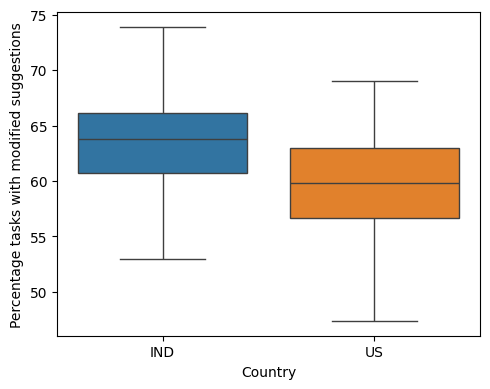

In [5]:
plt.figure(figsize=(5, 4))
sns.boxplot({'IND': perc_tasks_edited_ind, 'US': perc_tasks_edited_us}, showfliers=False)
plt.ylabel('Percentage tasks with modified suggestions')
plt.xlabel('Country')
plt.tight_layout()
plt.savefig('plots/suggestions_modified_boxplot.png')
plt.show()

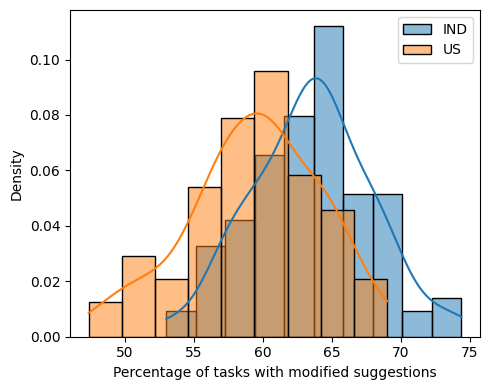

In [11]:
plt.figure(figsize=(5, 4))
sns.histplot(perc_tasks_edited_ind, label='IND', fill=True, kde=True, stat='density')
sns.histplot(perc_tasks_edited_us, label='US', fill=True, kde=True, stat='density')
plt.xlabel('Percentage of tasks with modified suggestions')
plt.legend()
plt.tight_layout()
plt.savefig('plots/suggestions_modified_densityplot.png')

In [47]:
print(np.mean(perc_tasks_edited_ind), np.std(perc_tasks_edited_ind))
print(np.mean(perc_tasks_edited_us), np.std(perc_tasks_edited_us))

63.52619959536453 4.264832209103469
59.36515478015444 4.757163663508504


### Efficiency metrics (time/length)

In [3]:
dfp['num_words'] = dfp['finalHtml_stripped'].apply(lambda x: len(x.split()))
dfp['words_per_second'] = dfp['num_words'] / dfp['duration_s']

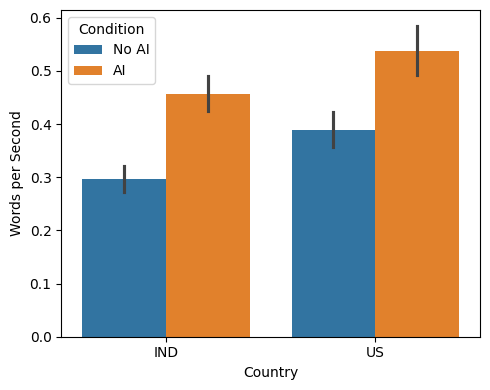

In [192]:
plt.figure(figsize=(5, 4))
sns.barplot(x='country', y='words_per_second', hue='group', hue_order=groups, data=dfp, order=countries)
plt.xlabel('Country')
plt.ylabel('Words per Second')
plt.legend(title='Condition')
plt.tight_layout()
plt.savefig('plots/productivity.png')

In [193]:
# Perform statistical tests
dft = dfp[dfp.country == 'IND']

df_normality = utils.perform_normality_test(dft, ["words_per_second"], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ["words_per_second"], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

,col,shapiro_No AI,shapiro_AI,shapiro_No AI_interpretation,shapiro_AI_interpretation
0,words_per_second,0.000042,0.000007,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,words_per_second,3609.000000,0.000000,-0.477865,True


In [4]:
# Check the efficiency gained per suggestion
dft = dfp[dfp.group == TREATMENT_LABEL].copy()

dft = dft[dft.accepted > 0]
dft['value_per_suggestion'] = dft['words_per_second'] / dft['accepted']

In [197]:
# For each number of accepted suggestion in a task, check how many Indian and US participants have that number of accepted suggestions
dft.groupby(['accepted', 'country']).size()

accepted  country
1         IND         3
          US          5
2         IND         8
          US         10
3         IND        12
          US         12
4         IND        10
          US         14
5         IND        25
          US         15
6         IND        21
          US         19
7         IND        18
          US         18
8         IND        18
          US          6
9         IND         9
          US          2
10        IND         7
          US          1
11        IND         3
          US          2
12        IND         3
          US          1
15        IND         2
16        IND         2
18        IND         2
dtype: int64

In [5]:
dftt = dft[(dft.accepted <= 7)]

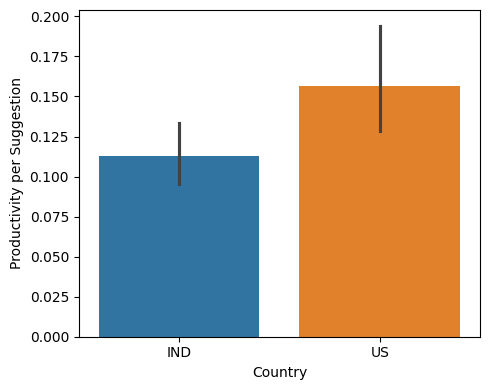

In [6]:
plt.figure(figsize=(5, 4))
sns.barplot(x='country', y='value_per_suggestion', data=dftt, order=countries, hue='country')
plt.xlabel('Country')
plt.ylabel('Productivity per Suggestion')
plt.tight_layout()
plt.savefig('plots/value_per_suggestion.png')

In [201]:
# Perform statistical tests
df_normality = utils.perform_normality_test(dft, ["value_per_suggestion"], filter_col='country', filter_vals=countries)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ["value_per_suggestion"], filter_col='country', filter_vals=countries, test_name='mannwhitney')
display(df_stats)

,col,shapiro_IND,shapiro_US,shapiro_IND_interpretation,shapiro_US_interpretation
0,value_per_suggestion,2.136883e-16,1.393351e-15,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,value_per_suggestion,5424.000000,0.000190,-0.277522,True


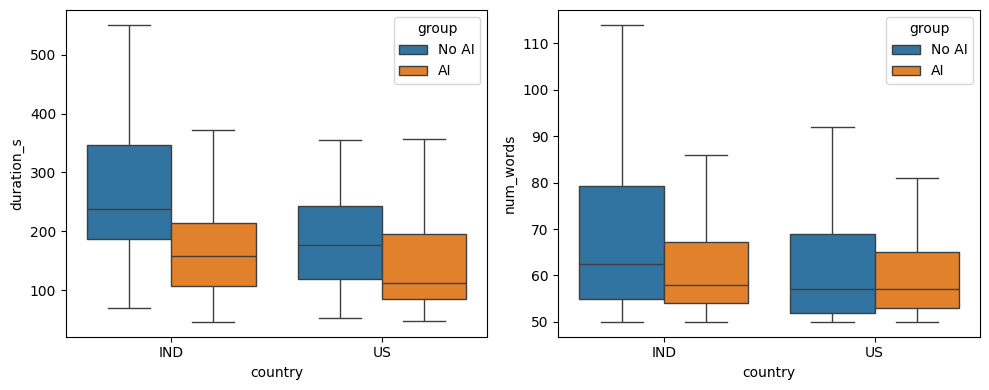

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.boxplot(x='country', y='duration_s', hue='group', hue_order=groups, data=dfp, showfliers=False, order=countries, ax=axs[0])
sns.boxplot(x='country', y='num_words', hue='group', hue_order=groups, data=dfp, showfliers=False, order=countries, ax=axs[1])
plt.tight_layout()
plt.show()

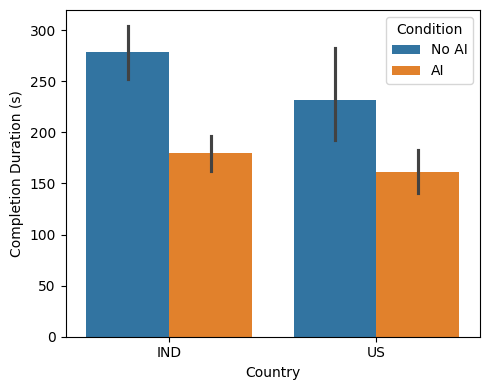

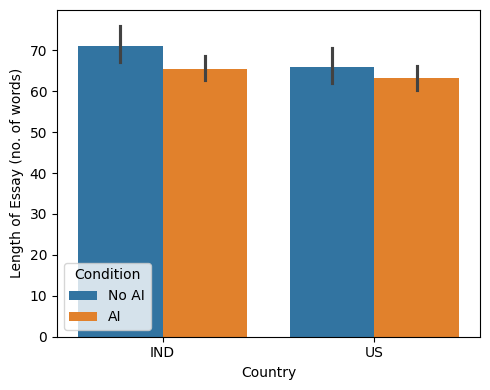

In [115]:
plt.figure(figsize=(5, 4))
# sns.boxplot(x='country', y='duration_s', hue='group', hue_order=groups, data=dfp, showfliers=False, order=countries)
sns.barplot(x='country', y='duration_s', hue='group', hue_order=groups, data=dfp, order=countries)
plt.xlabel('Country')
plt.ylabel('Completion Duration (s)')
plt.tight_layout()
plt.legend(title='Condition')
plt.savefig('plots/completion_duration.png')

plt.figure(figsize=(5, 4))
# sns.boxplot(x='country', y='num_words', hue='group', hue_order=groups, data=dfp, showfliers=False, order=countries)
sns.barplot(x='country', y='num_words', hue='group', hue_order=groups, data=dfp, order=countries)
plt.xlabel('Country')
plt.ylabel('Length of Essay (no. of words)')
plt.tight_layout()
plt.legend(title='Condition')
plt.savefig('plots/essay_length.png')

In [63]:
dfp[dfp['country'] == 'US'].groupby('group')['duration_s'].agg(['mean', 'std'])

,mean,std
group,,
AI,161.175405,117.722169
No AI,232.042353,240.162400


In [32]:
dfp[(dfp['country'] == 'US') & (dfp['group'] == TREATMENT_LABEL)]['duration_s'].mean() - dfp[(dfp['country'] == 'US') & (dfp['group'] == CONTROL_LABEL)]['duration_s'].mean()

-70.86694827586211

In [19]:
# Perform statistical tests
dft = dfp[dfp.country == 'IND']

df_normality = utils.perform_normality_test(dft, ["duration_s", "num_words"], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ["duration_s", "num_words"], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

,col,shapiro_No AI,shapiro_AI,shapiro_No AI_interpretation,shapiro_AI_interpretation
0,duration_s,2.460012e-05,5.415328e-10,Not normal,Not normal
1,num_words,1.069569e-09,6.738201e-15,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,duration_s,10356.000000,0.000000,0.498264,True
1,num_words,7872.500000,0.068239,0.138961,False


In [138]:
# Difference in difference analysis

import statsmodels.formula.api as smf

# Create the necessary variables
dfp['ai_treatment'] = dfp['group'].apply(lambda x: 1 if x == TREATMENT_LABEL else 0)
dfp['country_ind'] = dfp['country'].apply(lambda x: 1 if x == 'IND' else 0)
dfp['interaction'] = dfp['ai_treatment'] * dfp['country_ind']

# Fit the OLS model
model = smf.ols('duration_s ~ ai_treatment + country_ind + interaction', data=dfp).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             duration_s   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     12.33
Date:                Sun, 18 Aug 2024   Prob (F-statistic):           8.98e-08
Time:                        00:03:33   Log-Likelihood:                -3054.5
No. Observations:                 472   AIC:                             6117.
Df Residuals:                     468   BIC:                             6134.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      232.0424     14.584     15.911   

### TTR/Complexity metrics

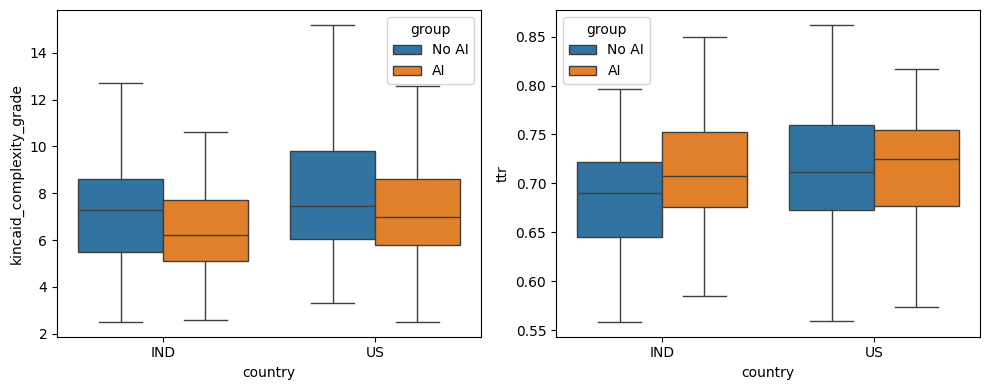

In [17]:
import textstat

dfp['kincaid_complexity_grade'] = dfp['finalHtml_stripped'].apply(textstat.flesch_kincaid_grade)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x='country', y='kincaid_complexity_grade', hue='group', order=countries, data=dfp, showfliers=False, hue_order=groups, ax=axs[0])
sns.boxplot(x='country', y='ttr', hue='group', order=countries, data=dfp, showfliers=False, hue_order=groups, ax=axs[1])
plt.tight_layout()

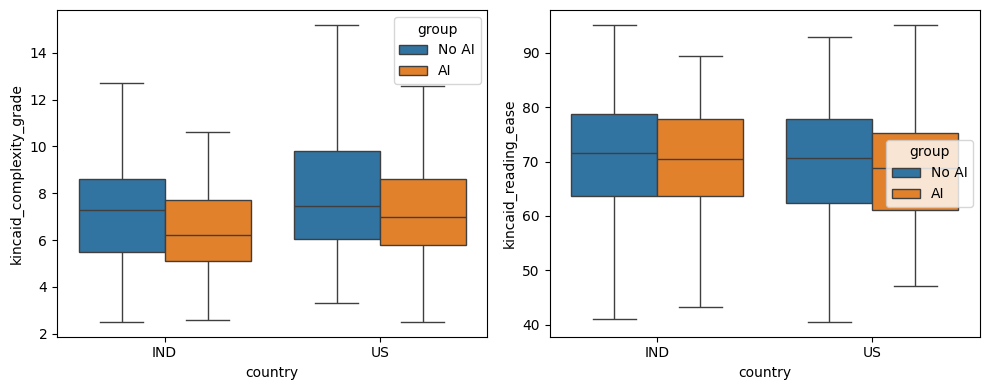

In [17]:
import textstat

dfp['kincaid_complexity_grade'] = dfp['finalHtml_stripped'].apply(textstat.flesch_kincaid_grade)
dfp['kincaid_reading_ease'] = dfp['finalHtml_stripped'].apply(textstat.flesch_reading_ease)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(x='country', y='kincaid_complexity_grade', hue='group', order=countries, data=dfp, showfliers=False, hue_order=groups, ax=axs[0])
sns.boxplot(x='country', y='kincaid_reading_ease', hue='group', order=countries, data=dfp, showfliers=False, hue_order=groups, ax=axs[1])
plt.tight_layout()

<Axes: xlabel='country', ylabel='readability_per_suggestion'>

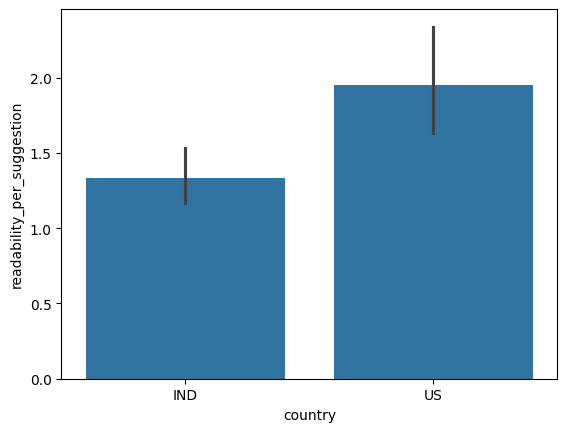

In [ ]:
# Check readability improvement per suggestion
############## DOES THIS EVEN MAKE ANY SENSE? ################

dft = dfp[dfp.group == TREATMENT_LABEL].copy()

dft = dft[dft.accepted > 0]
dft['readability_per_suggestion'] = dft['kincaid_complexity_grade'] / dft['accepted']

sns.barplot(x='country', y='readability_per_suggestion', order=countries, data=dft)

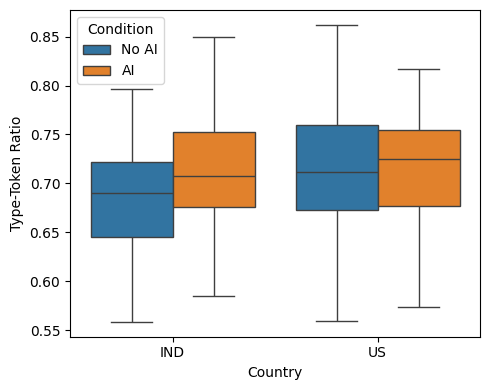

In [7]:
plt.figure(figsize=(5, 4))
sns.boxplot(x='country', y='ttr', hue='group', order=countries, data=dfp, showfliers=False, hue_order=groups)
# sns.barplot(x='country', y='ttr', hue='group', order=countries, data=dfp, hue_order=groups)
plt.xlabel('Country')
plt.ylabel('Type-Token Ratio')
plt.tight_layout()
plt.legend(title='Condition')
plt.savefig('plots/overall_ttr.png')
plt.show()

In [11]:
# Perform statistical tests for ttr
dft = dfp[(dfp.country == 'IND')]

df_normality = utils.perform_normality_test(dft, ['ttr'], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='group', filter_vals=groups, test_name='ttest')
display(df_stats)

,col,shapiro_No AI,shapiro_AI,shapiro_No AI_interpretation,shapiro_AI_interpretation
0,ttr,0.17509,0.00537,Normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,ttr,6601.000000,0.804526,-0.018876,False


,col,t_stat,p_value,cohens_d,df,significant
0,ttr,-0.097003,0.922809,-0.012737,230.000000,False


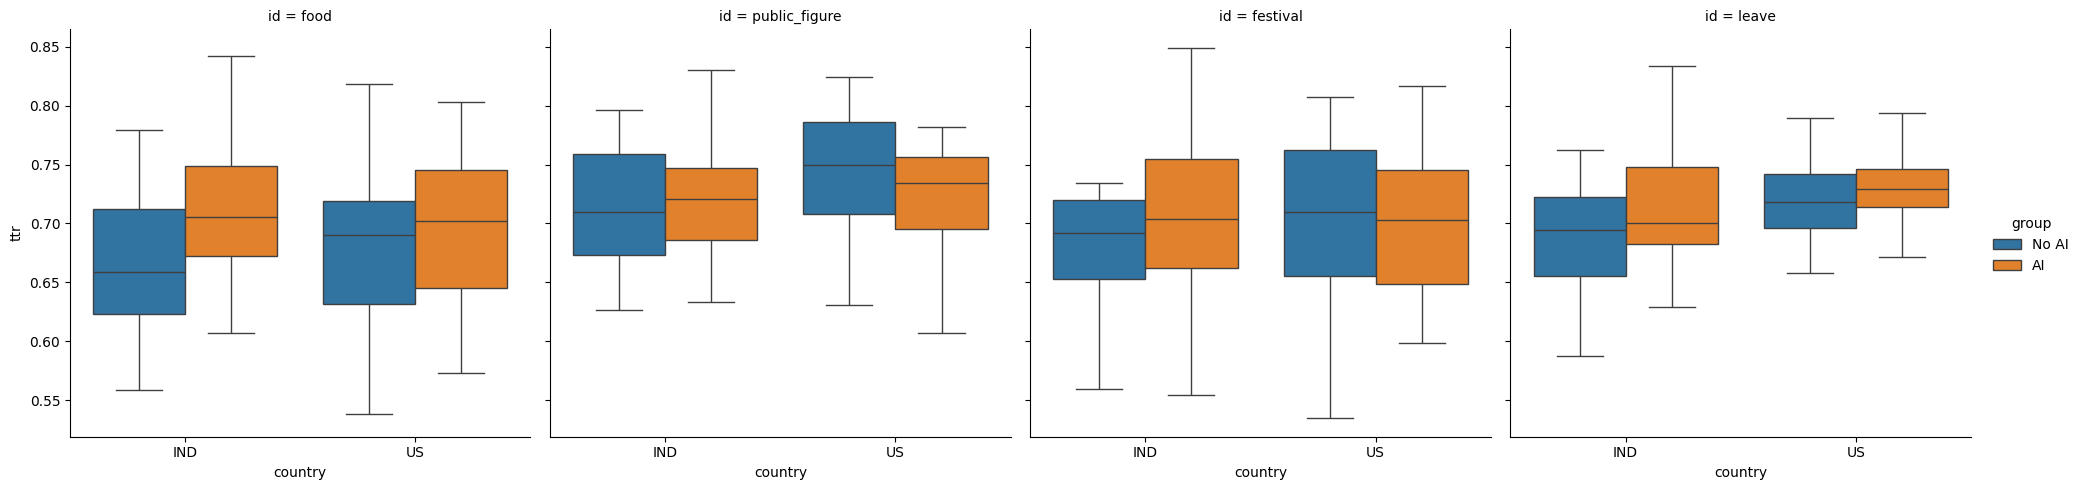

In [436]:
sns.catplot(x='country', y='ttr', hue='group', col='id', data=dfp, kind='box', showfliers=False, hue_order=groups)

<Figure size 1000x400 with 0 Axes>

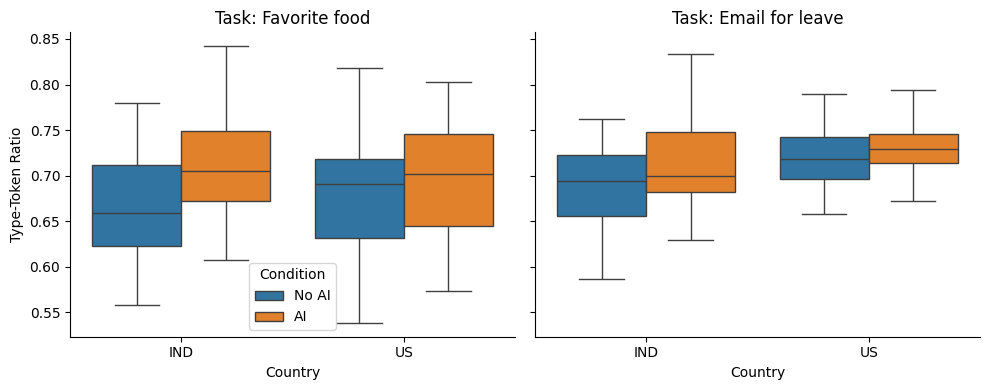

In [62]:
plt.figure(figsize=(10, 4))
g = sns.catplot(x='country', y='ttr', hue='group', col='id', data=dfp[dfp.id.isin(["food", "leave"])],
            kind='box', showfliers=False, hue_order=groups, col_wrap=2, legend_out=False, height=4, aspect=1.25)
# g = sns.catplot(x='country', y='ttr', hue='group', col='id', data=dfp[dfp.id.isin(["food", "leave"])],
#             kind='bar', hue_order=groups, col_wrap=2, legend_out=False, height=4, aspect=1.25)
g.set_axis_labels("Country", "Type-Token Ratio")

# Set custom titles for each plot
titles = {"food": "Task: Favorite food", "leave": "Task: Email for leave"}
g.set_titles("{col_name}", col_template="{col_name}", row_template="{row_name}")

# Apply custom titles
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(titles[title])

# Update legend title
g.add_legend(title="Condition")

plt.tight_layout()
plt.savefig('plots/ttr_per_task.png')
plt.show()

In [218]:
dfp[(dfp.id == 'leave')].groupby(['country', 'group'])['ttr'].mean()

country  group
IND      AI       0.710656
         No AI    0.687835
US       AI       0.727502
         No AI    0.724239
Name: ttr, dtype: float64

In [236]:
# Perform statistical tests for ttr across tasks
dft = dfp[(dfp.country == 'US') & (dfp.id == 'public_figure')]

df_normality = utils.perform_normality_test(dft, ['ttr'], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='group', filter_vals=groups, test_name='ttest')
display(df_stats)

,col,shapiro_No AI,shapiro_AI,shapiro_No AI_interpretation,shapiro_AI_interpretation
0,ttr,0.175643,0.003049,Normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,ttr,513.000000,0.152391,0.219976,False


,col,t_stat,p_value,cohens_d,df,significant
0,ttr,1.456109,0.150946,0.382393,56.000000,False


In [15]:
# Perform statistical tests for ttr across tasks
dft = dfp[dfp.group == TREATMENT_LABEL]

df_normality = utils.perform_normality_test(dft, ['ttr'], filter_col='country', filter_vals=countries)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='country', filter_vals=countries, test_name='mannwhitney')
display(df_stats)

df_stats = utils.perform_statistical_test(dft, ['ttr'], filter_col='country', filter_vals=countries, test_name='ttest')
display(df_stats)

,col,shapiro_IND,shapiro_US,shapiro_IND_interpretation,shapiro_US_interpretation
0,ttr,0.603914,0.00537,Normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,ttr,7784.000000,0.346425,-0.068008,False


,col,t_stat,p_value,cohens_d,df,significant
0,ttr,-0.322999,0.746958,-0.040297,258.000000,False


### Check for significantly different variance with and without AI (test for intra-group homogenization)

In [176]:
# Separate the data into AI and No AI groups
var = 'ttr'
no_ai_group = dfp[(dfp['group'] == CONTROL_LABEL) & (dfp['country'] == 'IND')][var]
ai_group = dfp[(dfp['group'] == TREATMENT_LABEL) & (dfp['country'] == 'IND')][var]

# Perform Levene's test
print(stats.levene(ai_group, no_ai_group))
print(f"Variances:\nNo AI: {np.var(no_ai_group):0.3f} | AI: {np.var(ai_group):0.3f}")
print(f"Variance decreases with AI? {np.var(no_ai_group) > np.var(ai_group)}")

LeveneResult(statistic=0.04074508142599813, pvalue=0.8402032044347494)
Variances:
No AI: 0.003 | AI: 0.003
Variance decreases with AI? False


### Sentiment Analysis

In [57]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

dfp['sentiment_polarity'] = dfp['finalHtml_stripped'].apply(analyze_sentiment)

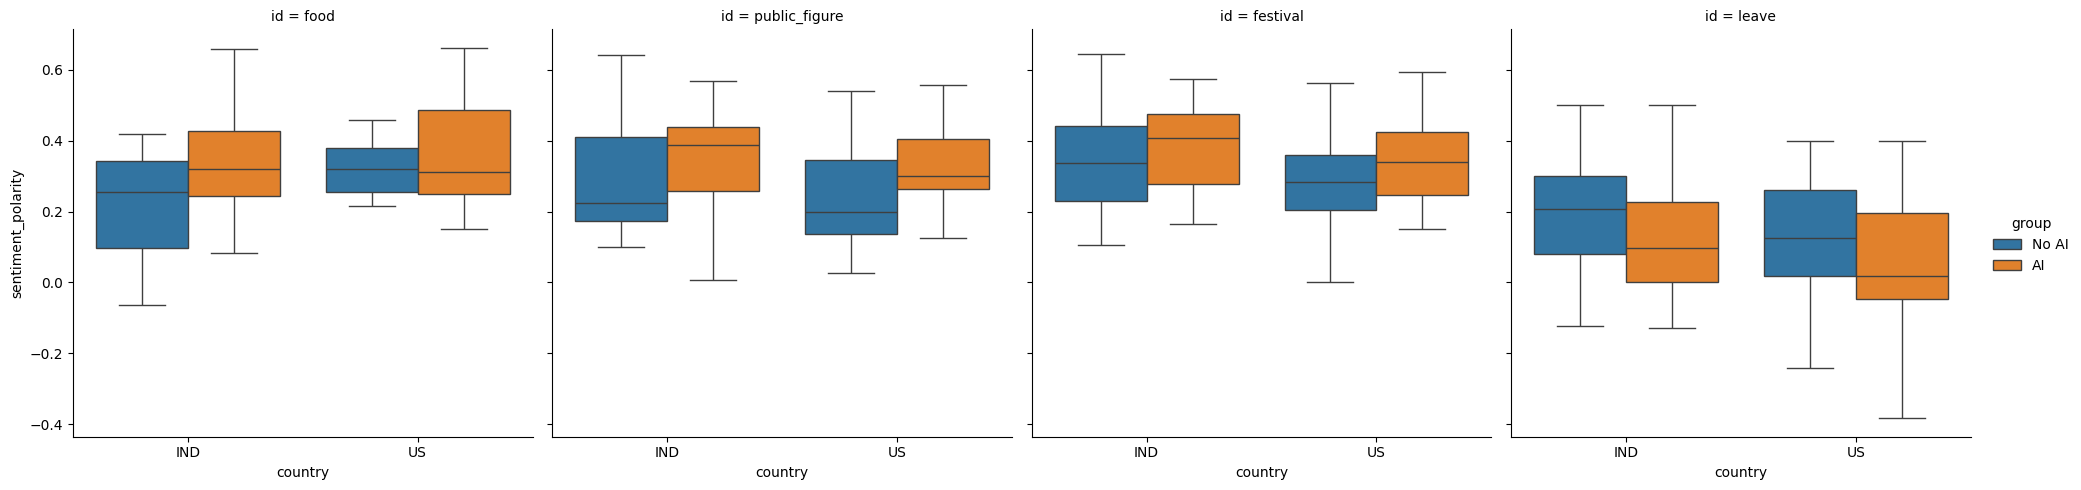

In [58]:
sns.catplot(x='country', y='sentiment_polarity', hue='group', hue_order=groups, data=dfp, showfliers=False, order=countries, kind='box', col='id')

In [72]:
# Perform statistical tests for sentiment
dft = dfp[(dfp.country == 'US') & (dfp.id == 'leave')]

df_normality = utils.perform_normality_test(dft, ['sentiment_polarity'], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ['sentiment_polarity'], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

df_stats = utils.perform_statistical_test(dft, ['sentiment_polarity'], filter_col='group', filter_vals=groups, test_name='ttest')
display(df_stats)

,col,shapiro_No AI,shapiro_AI
0,sentiment_polarity,Not normal,Normal


,col,u_stat,p_value,significant
0,sentiment_polarity,674.500000,0.075361,False


,col,t_stat,p_value,significant
0,sentiment_polarity,1.458525,0.149586,False


### Politeness

In [82]:
import convokit
from convokit import Corpus, download, Classifier
from convokit.text_processing import TextParser
from convokit import PolitenessStrategies


train_corpus = Corpus(filename=download('wiki-politeness-annotated', data_dir='data/'))
train_corpus = Corpus(utterances=[utt for utt in train_corpus.iter_utterances() if utt.meta["Binary"] != 0])

# Parse the corpus
parser = TextParser(verbosity=10000)
parser.transform(train_corpus)

# Compute politeness strategies
ps = PolitenessStrategies()
ps.transform(train_corpus)

clf = Classifier(obj_type='utterance', pred_feats=['politeness_strategies'], labeller=lambda utt: utt.meta['Binary']==1)
clf.fit(train_corpus)

Dataset already exists at /Users/agdhruv/Desktop/culturally-aware-ai/caai-portal/analysis/data/wiki-politeness-annotated
2178/2178 utterances processed
Initialized default classification model (standard scaled logistic regression).


In [83]:
# Convert the data into a corpus
utts = []
for idx, row in dfp.iterrows():
    speaker = row['user_id']
    text = row['finalHtml_stripped']
    speaker = convokit.Speaker(id=speaker)
    utterance = convokit.Utterance(id=idx, speaker=speaker, text=text, meta={'task_id': row['id'], 'user_id': row['user_id']})
    utts.append(utterance)

corpus = convokit.Corpus(utterances=utts)
parser.transform(corpus)
ps.transform(corpus, markers=True)

# Compute politeness score
clf.transform(corpus)
pred_result = clf.summarize(corpus)


472/472 utterances processed


In [84]:
# Extract politeness strategy results into df
politeness_scores = []
for utt in corpus.iter_utterances():
    politeness_scores.append((utt.meta['politeness_strategies'], utt.meta['pred_score'], utt.meta['task_id'], utt.meta['user_id']))

df_politeness = pd.DataFrame(politeness_scores, columns=['politeness_strategies', 'pred_score', 'task_id', 'user_id'])
df_politeness['num_politeness_markers'] = df_politeness['politeness_strategies'].apply(lambda x: sum(x.values()))
dft = dfp.join(df_politeness.set_index(['task_id', 'user_id'])[['num_politeness_markers', 'pred_score']], on=['id', 'user_id'])

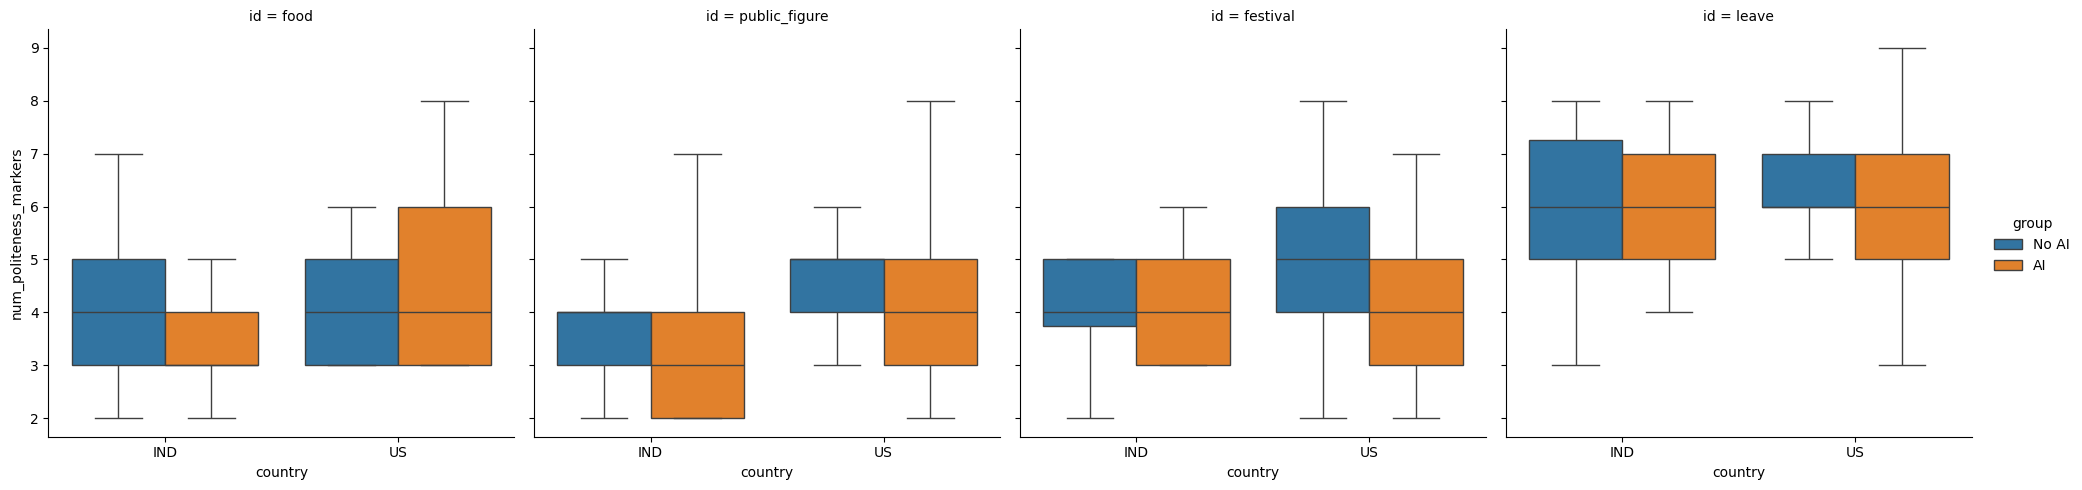

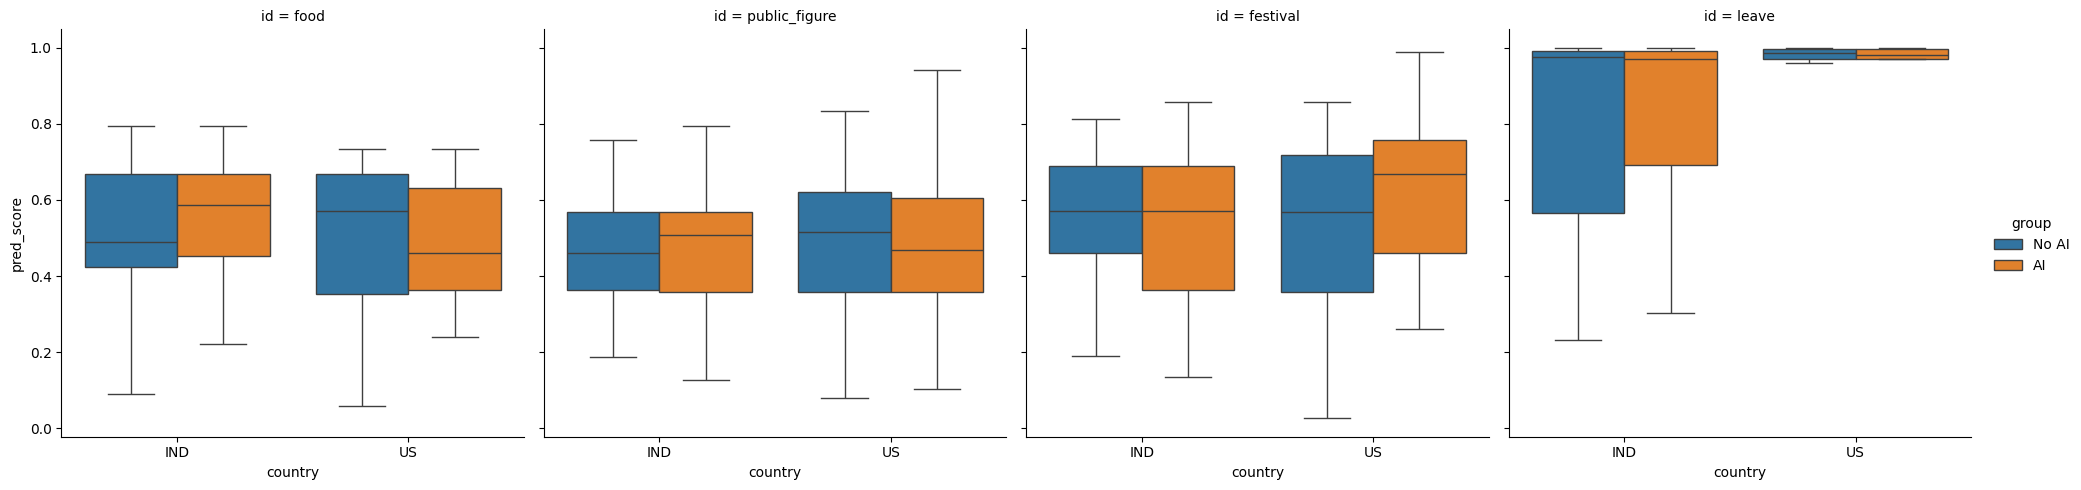

In [402]:
sns.catplot(x='country', y='num_politeness_markers', hue='group', hue_order=groups, data=dft, showfliers=False, order=countries, kind='box', col='id')
sns.catplot(x='country', y='pred_score', hue='group', hue_order=groups, data=dft, showfliers=False, order=countries, kind='box', col='id')

In [86]:
# Perform statistical tests
dftt = dft[(dft.country == 'IND') & (dft.id == 'leave')]

df_normality = utils.perform_normality_test(dftt, ['pred_score'], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dftt, ['pred_score'], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

df_stats = utils.perform_statistical_test(dftt, ['pred_score'], filter_col='group', filter_vals=groups, test_name='ttest')
display(df_stats)

,col,shapiro_No AI,shapiro_AI
0,pred_score,Not normal,Not normal


,col,u_stat,p_value,significant
0,pred_score,450.000000,0.791426,False


,col,t_stat,p_value,significant
0,pred_score,-0.035258,0.971995,False


### Topic analysis

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

dft = dfp.copy()
dft= dft[dft.id == 'festival']

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
dft['processed_text'] = dft['finalHtml_stripped'].apply(preprocess_text)

# Vectorize text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(dft['processed_text'])

from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics
n_topics = 4  # You can change this number based on your dataset

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(dtm)

def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([words[i] for i in topic.argsort()[:-top_n - 1:-1]])

# Print the topics and top words
print_topics(lda_model, vectorizer)

Topic 0:
['festival', 'celebrate', 'day', 'family', 'favorite', 'food', 'onam', 'state', 'kerala', 'traditional']
Topic 1:
['christmas', 'love', 'holiday', 'family', 'favorite', 'year', 'gift', 'celebrate', 'tree', 'present']
Topic 2:
['holiday', 'time', 'favorite', 'family', 'halloween', 'christmas', 'love', 'friend', 'year', 'like']
Topic 3:
['festival', 'diwali', 'light', 'sweet', 'family', 'home', 'favorite', 'celebrated', 'day', 'joy']


In [44]:
topic_mapping = {
    0: 'onam',
    1: 'xmas',
    2: 'halloween',
    3: 'diwali',
}

# Get the topic distribution for each document
topic_results = lda_model.transform(dtm)
# Assign the dominant topic to each document
dft['dominant_topic'] = topic_results.argmax(axis=1)
dft['dominant_topic_label'] = dft['dominant_topic'].map(topic_mapping)

In [38]:
# print("\n\n".join(dft[dft['dominant_topic_label'] == 'chicken']['finalHtml_stripped'].tolist()))

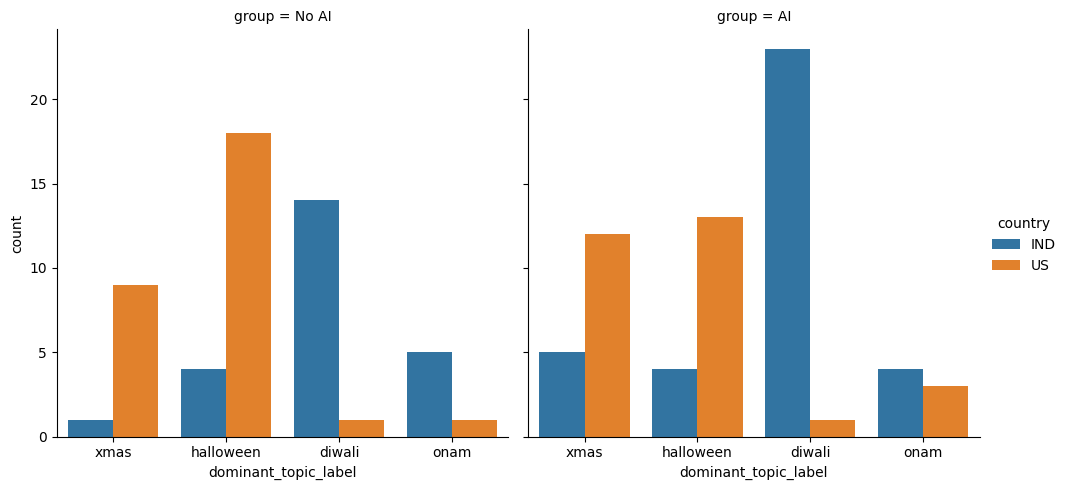

In [45]:
sns.catplot(data=dft, x='dominant_topic_label', hue='country', hue_order=countries, kind='count', col='group', col_order=groups)

In [76]:
dft = dfp.copy()
dft['processed_text'] = dft['finalHtml_stripped'].apply(preprocess_text)

def hapax_legomena(text):
    words = text.split()
    frequency = {word: words.count(word) for word in words}
    return len([word for word, count in frequency.items() if count == 1]) / len(words)
dft['hapax_legomena'] = dft['processed_text'].apply(hapax_legomena)

def hapax_dislegomena(text):
    words = text.split()
    frequency = {word: words.count(word) for word in words}
    return len([word for word, count in frequency.items() if count == 2]) / len(words)
dft['hapax_dislegomena'] = dft['processed_text'].apply(hapax_dislegomena)

def avg_sentence_length(text):
    sentences = text.split('.')
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)
dft['avg_sentence_length'] = dft['finalHtml_stripped'].apply(avg_sentence_length)

informal_markers = ['i', "i'm", 'we', "we're", 'you', 'your', "you're", "i'll", "we'll", 'me', 'us']
def formality_score(text):
    words = text.lower().split()
    return 1 - (sum(1 for word in words if word in informal_markers) / len(words))
dft['formality_score'] = dft['finalHtml_stripped'].apply(formality_score)

<Axes: xlabel='country', ylabel='hapax_legomena'>

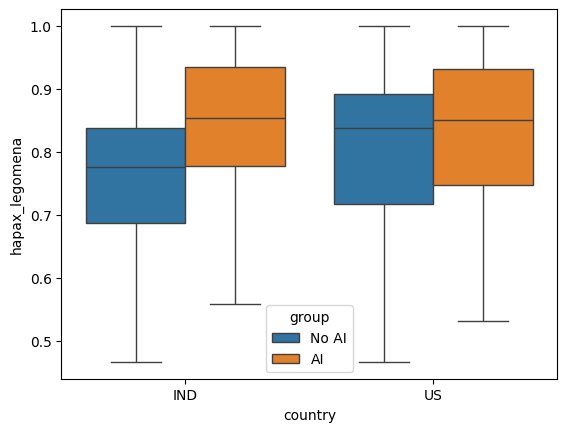

In [84]:
sns.boxplot(data=dft, y='hapax_legomena', x='country', hue='group', order=countries, hue_order=groups, showfliers=False)

<Axes: xlabel='country', ylabel='avg_sentence_length'>

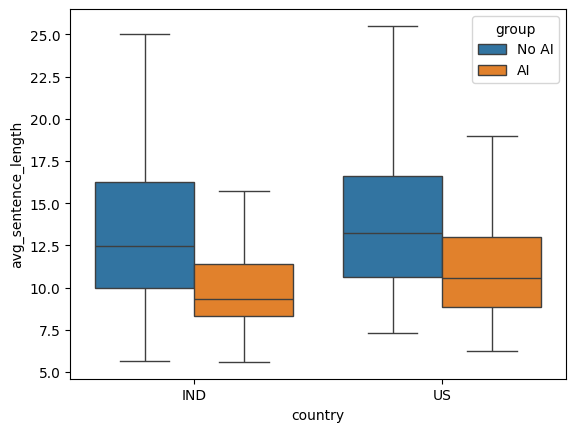

In [86]:
sns.boxplot(data=dft, y='avg_sentence_length', x='country', hue='group', order=countries, hue_order=groups, showfliers=False)